In [19]:

import os
import pandas as pd
# Need s3fs as well
import dotenv
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
coins = ['avalanche-2', ## check?
'binancecoin', ##
'bitcoin', ##
'cardano', ## 
'dogecoin', ##
'ethereum', ## 
'polkadot', ## 
'ripple', ## check, XRP?
'solana', ## 
'terra-luna'] ## check

In [21]:
dotenv.load_dotenv('.env', override=True)

AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

price_data = []

for coin in coins:

    price_df = pd.read_csv(
        f"s3://{AWS_S3_BUCKET}/{coin}.csv",
        storage_options={
            "key": AWS_ACCESS_KEY_ID,
            "secret": AWS_SECRET_ACCESS_KEY
        },
    )

    price_df.index = pd.to_datetime(price_df['Day'], format='%Y-%m-%d')
    price_df.drop(columns=['Day'], inplace=True)

    price_data.append(price_df)
    

In [22]:
price_data[0]

,Price,Market Cap,Volume
Day,,,
2021-09-01,39.62,6.930748e+09,8.036312e+08
2021-09-02,42.44,7.488956e+09,9.921274e+08
2021-09-03,47.53,8.208052e+09,8.837715e+08
2021-09-04,45.81,8.054269e+09,1.237827e+09
2021-09-05,47.25,8.366989e+09,8.654498e+08
...,...,...,...
2022-02-25,76.61,1.883056e+10,2.333968e+09
2022-02-26,80.98,1.992930e+10,1.478105e+09
2022-02-27,81.63,2.003718e+10,1.091134e+09


In [26]:
predict_days = 31


for coin_idx in range(len(coins)):
    coin_name = coins[coin_idx]
    cur_price_data = price_data[coin_idx]
    loaded_model = SARIMAXResults.load(f'models/{coin_name}.pkl')

    sarima_y_pred = loaded_model.get_forecast(predict_days)
    sarima_y_pred_df = sarima_y_pred.conf_int(alpha = 0.05) 
    sarima_y_pred_df["Predictions"] = loaded_model.predict(start = sarima_y_pred_df.index[0], end = sarima_y_pred_df.index[-1])

    sarima_y_pred_df.index.name = 'Date'

    sarima_y_pred_df.to_csv(f'predictions/{coin_name}.csv')

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [24]:
sarima_y_pred_df

,lower Price,upper Price,Predictions
Date,,,
2022-03-02,83.753353,100.196817,91.975085
2022-03-03,80.059887,103.217282,91.638584
2022-03-04,79.928636,108.551646,94.240141
2022-03-05,78.821067,113.464112,96.142590
2022-03-06,74.469802,114.822561,94.646181
2022-03-07,73.317108,118.198981,95.758044
2022-03-08,71.349987,120.792894,96.071441
2022-03-09,68.956548,122.631348,95.793948
2022-03-10,67.100913,124.618426,95.859669


Text(0.5, 1.0, 'Train/Test split for BTC Data')

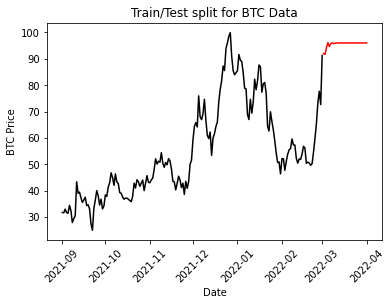

In [25]:
plt.plot(cur_price_data['Price'], color = "black", label = 'Train')
plt.plot(sarima_y_pred_df['Predictions'], color = "red", label = 'Test')

plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
